# 데이터 크롤링

## 기본 설치

In [ ]:
!pip install selenium
!apt-get update

# (최초 1회)
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver '/content/drive/MyDrive/Colab Notebooks'
!pip install chromedriver-autoinstaller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,553 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ub

In [ ]:
!python --version

import selenium
print(selenium.__version__)

Python 3.10.12
4.31.1


In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import sys
from selenium.webdriver.common.keys import Keys
import urllib.request
import os
from urllib.request import urlretrieve

import time
import pandas as pd
import numpy as np
import chromedriver_autoinstaller  # setup chrome options

In [ ]:
chrome_path = "/content/drive/MyDrive/Colab Notebooks/chromedriver"

sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')  # set path to chromedriver as per your configuration
chrome_options.add_argument('lang=ko_KR') # 한국어

chromedriver_autoinstaller.install()  # set the target URL

## 에센스/세럼/엠플

### 링크 크롤링

In [ ]:
import re

# selenium driver 로드
driver = webdriver.Chrome(options=chrome_options)

# URL 구조
base_url = "https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010014&fltDispCatNo=&prdSort=01&pageIdx={}&rowsPerPage=48&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=2&aShowCnt=0&bShowCnt=0&cShowCnt=0&trackingCd=Cat100000100010014_Small&amplitudePageGubun=&t_page=&t_click=&midCategory=%EC%97%90%EC%84%BC%EC%8A%A4%2F%EC%84%B8%EB%9F%BC%2F%EC%95%B0%ED%94%8C&smallCategory=%EC%A0%84%EC%B2%B4&checkBrnds=&lastChkBrnd="

# 페이지 범위 설정
start_page = 1
end_page = 4

url_list = []

for page_num in range(start_page, end_page + 1):
    url = base_url.format(page_num)

    # 링크 전달
    driver.get(url)

    # CSS_SELECTOR를 활용해서 <a> 태그가 포함된 section들 찾기
    # data-index 속성이 있는 <li> 태그만 선택
    sections = driver.find_elements(By.CSS_SELECTOR, "li[data-index]")

    # 섹션 내에서 <a> 태그의 href 속성을 가져오기

    for section in sections:
        a_tags = section.find_elements(By.TAG_NAME, "a")
        for a in a_tags:
            href = a.get_attribute("href")
            if href and "javascript:;" not in href: # javascript:; 가 없을 경우만 href 속성 가져오기
                url_list.append(href)

#driver 종료
driver.quit()

len(url_list)

192

### 상품 정보와 리뷰 크롤링

In [ ]:
import re

def scrape_product_info_and_reviews(url):
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)  # URL 열기

    try:
        try:
          # 리뷰 버튼 클릭
          WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="reviewInfo"]/a'))).click()
        except:
          pass

        try:
          # 도움순 클릭
          WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="gdasSort"]/li[2]/a'))).click()
        except:
          pass

        try:
          # 체험단 클릭
          WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="searchType_3"]'))).click()
        except:
          pass

        # 브랜드 정보
        try:
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'p.prd_brand')))
            brand_name = element.text
        except:
            brand_name = "N/A"

        # 제품명
        try:
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'p.prd_name')))
            product_name = element.text
        except:
            product_name = "N/A"

        # 가격 정보
        try:
            # 원래 가격
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'span.price-1 strike')))
            original_price = int(element.text.replace(',', ''))
        except:
            original_price = None

        try:
            # 최종 가격
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'span.price-2 strong')))
            final_price = int(element.text.replace(',', ''))
        except:
            final_price = None

        # 리뷰 등급
        try:
            review_grade_element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'p#repReview b')))
            review_grade = float(review_grade_element.text.strip())
        except:
            review_grade = None

        # 리뷰 수
        try:
            review_numbers_element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'p#repReview em')))
            review_numbers_text = review_numbers_element.text.strip('()').replace(',', '')
            review_numbers = int(re.sub(r'\D', '', review_numbers_text))
        except:
            review_numbers = None

        # 피부타입, 피부고민, 자극도 항목별 퍼센트 크롤링

        try:
            # 피부타입
            percentages = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'dl.poll_type2.type3 ul.list li em.per')))
            dry = int(percentages[0].text.strip('%'))
            combination = int(percentages[1].text.strip('%'))
            oily = int(percentages[2].text.strip('%'))
        except:
            dry = combination = oily = None

        try:
            # 피부고민
            percentages = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'dl.poll_type2.type3 ul.list li em.per')))
            moisturizing = int(percentages[3].text.strip('%'))
            soothing = int(percentages[4].text.strip('%'))
            whitening = int(percentages[5].text.strip('%'))
        except:
            moisturizing = soothing = whitening = None

        try:
            # 자극도
            percentages = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'dl.poll_type2.type3 ul.list li em.per')))
            no_irritation = int(percentages[6].text.strip('%'))
            moderate_irritation = int(percentages[7].text.strip('%'))
            yes_irritation = int(percentages[8].text.strip('%'))
        except:
            no_irritation = moderate_irritation = yes_irritation = None

        # 리뷰 수집
        reviews = []
        try:
            review_list = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'ul.inner_list > li')))
            for review in review_list:
                review_text = review.find_element(By.CSS_SELECTOR, 'div.txt_inner').text
                # 줄바꿈과 이모티콘 제거
                review_text = review_text.replace('\n', ' ').replace('\r', ' ')
                review_text = re.sub(r'[^\w\s,.!?]', '', review_text)
                reviews.append(review_text.strip())
        except:
            reviews = []

    finally:
        driver.quit()  # 드라이버 닫기

    # 데이터를 딕셔너리로 저장
    data = {
        "브랜드": [brand_name],
        "제품명": [product_name],
        "원래 가격": [original_price],
        "최종 가격": [final_price],
        "리뷰 등급": [review_grade],
        "리뷰 수": [review_numbers],
        "건성에 좋아요": [dry],
        "복합성에 좋아요": [combination],
        "지성에 좋아요": [oily],
        "보습에 좋아요": [moisturizing],
        "진정에 좋아요": [soothing],
        "주름/미백에 좋아요": [whitening],
        "자극없이 순해요": [no_irritation],
        "보통이에요": [moderate_irritation],
        "자극이 느껴져요": [yes_irritation],
        "리뷰": [reviews]
    }

    # 데이터프레임으로 만들기
    df = pd.DataFrame(data)

    return df

In [ ]:
import pandas as pd
from tqdm import tqdm  # tqdm 라이브러리를 임포트합니다.

# 데이터프레임을 저장할 빈 리스트 초기화
result_product_list = []

# 각 URL에 대해 데이터 스크래핑 실행
for link in tqdm(url_list, desc="Scraping progress"):
    product_df = scrape_product_info_and_reviews(link)
    result_product_list.append(product_df)

# 모든 데이터프레임을 하나로 연결
result_product_df = pd.concat(result_product_list, ignore_index=True)

# 데이터프레임 저장
result_product_df.to_excel("olive_young_essence_serum_ampoule.xlsx", index=False)

Scraping progress: 100%|██████████| 192/192 [1:12:11<00:00, 22.56s/it]


### 리뷰 개수 히스토그램

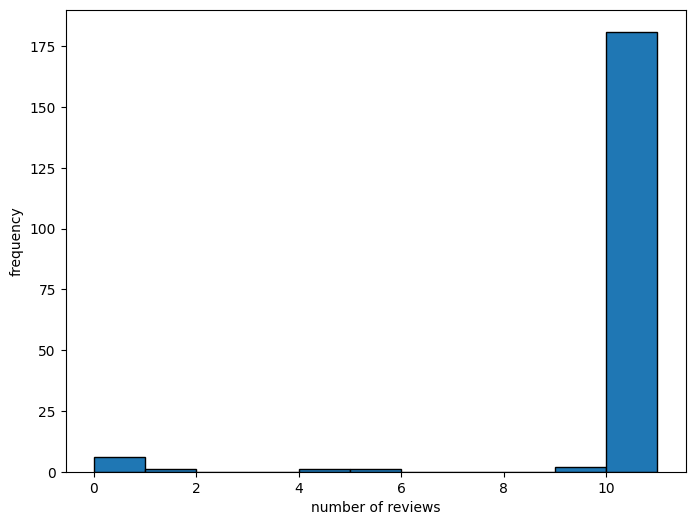

In [ ]:
import matplotlib.pyplot as plt

# 리뷰 리스트의 길이 (리스트 안의 항목 개수)를 계산하는 함수
result_product_df['리뷰_길이'] = result_product_df['리뷰'].apply(len)

# 히스토그램 시각화
plt.figure(figsize=(8, 6))
plt.hist(result_product_df['리뷰_길이'], bins=range(result_product_df['리뷰_길이'].min(), result_product_df['리뷰_길이'].max() + 2), edgecolor='black')
plt.xlabel('number of reviews')
plt.ylabel('frequency')
plt.show()

## 로션

### 링크 크롤링

In [ ]:
import re

# selenium driver 로드
driver = webdriver.Chrome(options=chrome_options)


url_list = []
url_lists = ["https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010016&fltDispCatNo=&prdSort=01&pageIdx=1&rowsPerPage=48&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=0&aShowCnt=&bShowCnt=&cShowCnt=&trackingCd=Cat100000100010016_Small&amplitudePageGubun=&t_page=&t_click=&midCategory=%EB%A1%9C%EC%85%98&smallCategory=%EC%A0%84%EC%B2%B4&checkBrnds=&lastChkBrnd=4",
            "https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010016&fltDispCatNo=&prdSort=01&pageIdx=2&rowsPerPage=48&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=0&aShowCnt=&bShowCnt=&cShowCnt=&trackingCd=Cat100000100010016_Small&amplitudePageGubun=&t_page=&t_click=&midCategory=%EB%A1%9C%EC%85%98&smallCategory=%EC%A0%84%EC%B2%B4&checkBrnds=&lastChkBrnd=4",
            "https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010016&fltDispCatNo=&prdSort=01&pageIdx=3&rowsPerPage=48&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=0&aShowCnt=&bShowCnt=&cShowCnt=&trackingCd=Cat100000100010016_Small&amplitudePageGubun=&t_page=&t_click=&midCategory=%EB%A1%9C%EC%85%98&smallCategory=%EC%A0%84%EC%B2%B4&checkBrnds=&lastChkBrnd=4",
            "https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010016&fltDispCatNo=&prdSort=01&pageIdx=4&rowsPerPage=48&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=0&aShowCnt=&bShowCnt=&cShowCnt=&trackingCd=Cat100000100010016_Small&amplitudePageGubun=&t_page=&t_click=&midCategory=%EB%A1%9C%EC%85%98&smallCategory=%EC%A0%84%EC%B2%B4&checkBrnds=&lastChkBrnd=4"]

for url in url_lists:

    # 링크 전달
    driver.get(url)


    # CSS_SELECTOR를 활용해서 <a> 태그가 포함된 section들 찾기
    # data-index 속성이 있는 <li> 태그만 선택
    sections = driver.find_elements(By.CSS_SELECTOR, "li[data-index]")

    # 섹션 내에서 <a> 태그의 href 속성을 가져오기

    for section in sections:
        a_tags = section.find_elements(By.TAG_NAME, "a")
        for a in a_tags:
            href = a.get_attribute("href")
            if href and "javascript:;" not in href: # javascript:; 가 없을 경우만 href 속성 가져오기
                url_list.append(href)


#driver 종료
driver.quit()



192

### 상품 정보와 리뷰 크롤링

In [ ]:
import re

def scrape_product_info_and_reviews(url):
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)  # URL 열기

    try:
        try:
          # 리뷰 버튼 클릭
          WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="reviewInfo"]/a'))).click()
        except:
          pass

        try:
          # 도움순 클릭
          WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="gdasSort"]/li[2]/a'))).click()
        except:
          pass

        try:
          # 체험단 클릭
          WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="searchType_3"]'))).click()
        except:
          pass

        # 브랜드 정보
        try:
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'p.prd_brand')))
            brand_name = element.text
        except:
            brand_name = "N/A"

        # 제품명
        try:
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'p.prd_name')))
            product_name = element.text
        except:
            product_name = "N/A"

        # 가격 정보
        try:
            # 원래 가격
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'span.price-1 strike')))
            original_price = int(element.text.replace(',', ''))
        except:
            original_price = None

        try:
            # 최종 가격
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'span.price-2 strong')))
            final_price = int(element.text.replace(',', ''))
        except:
            final_price = None

        # 리뷰 등급
        try:
            review_grade_element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'p#repReview b')))
            review_grade = float(review_grade_element.text.strip())
        except:
            review_grade = None

        # 리뷰 수
        try:
            review_numbers_element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'p#repReview em')))
            review_numbers_text = review_numbers_element.text.strip('()').replace(',', '')
            review_numbers = int(re.sub(r'\D', '', review_numbers_text))
        except:
            review_numbers = None

        # 피부타입, 피부고민, 자극도 항목별 퍼센트 크롤링

        try:
            # 피부타입
            percentages = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'dl.poll_type2.type3 ul.list li em.per')))
            dry = int(percentages[0].text.strip('%'))
            combination = int(percentages[1].text.strip('%'))
            oily = int(percentages[2].text.strip('%'))
        except:
            dry = combination = oily = None

        try:
            # 피부고민
            percentages = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'dl.poll_type2.type3 ul.list li em.per')))
            moisturizing = int(percentages[3].text.strip('%'))
            soothing = int(percentages[4].text.strip('%'))
            whitening = int(percentages[5].text.strip('%'))
        except:
            moisturizing = soothing = whitening = None

        try:
            # 자극도
            percentages = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'dl.poll_type2.type3 ul.list li em.per')))
            no_irritation = int(percentages[6].text.strip('%'))
            moderate_irritation = int(percentages[7].text.strip('%'))
            yes_irritation = int(percentages[8].text.strip('%'))
        except:
            no_irritation = moderate_irritation = yes_irritation = None

        # 리뷰 수집
        reviews = []
        try:
            review_list = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'ul.inner_list > li')))
            for review in review_list:
                review_text = review.find_element(By.CSS_SELECTOR, 'div.txt_inner').text
                # 줄바꿈과 이모티콘 제거
                review_text = review_text.replace('\n', ' ').replace('\r', ' ')
                review_text = re.sub(r'[^\w\s,.!?]', '', review_text)
                reviews.append(review_text.strip())
        except:
            reviews = []

    finally:
        driver.quit()  # 드라이버 닫기

    # 데이터를 딕셔너리로 저장
    data = {
        "브랜드": [brand_name],
        "제품명": [product_name],
        "원래 가격": [original_price],
        "최종 가격": [final_price],
        "리뷰 등급": [review_grade],
        "리뷰 수": [review_numbers],
        "건성에 좋아요": [dry],
        "복합성에 좋아요": [combination],
        "지성에 좋아요": [oily],
        "보습에 좋아요": [moisturizing],
        "진정에 좋아요": [soothing],
        "주름/미백에 좋아요": [whitening],
        "자극없이 순해요": [no_irritation],
        "보통이에요": [moderate_irritation],
        "자극이 느껴져요": [yes_irritation],
        "리뷰": [reviews]
    }

    # 데이터프레임으로 만들기
    df = pd.DataFrame(data)

    return df

In [ ]:
import pandas as pd
from tqdm import tqdm  # tqdm 라이브러리를 임포트합니다.

# 데이터프레임을 저장할 빈 리스트 초기화
result_product_list = []

# 각 URL에 대해 데이터 스크래핑 실행
for link in tqdm(url_list, desc="Scraping progress"):
    product_df = scrape_product_info_and_reviews(link)
    result_product_list.append(product_df)

# 모든 데이터프레임을 하나로 연결
result_product_df = pd.concat(result_product_list, ignore_index=False)

# 데이터프레임 저장
result_product_df.to_excel("olive_young_lotion.xlsx")


Scraping progress: 100%|██████████| 192/192 [1:57:15<00:00, 36.64s/it]


In [ ]:
# 중복된 행 찾기
duplicate_rows = result_product_df[result_product_df.duplicated(subset=['제품명'])]

# 중복된 행 출력
print("중복된 행:")
print(duplicate_rows)

중복된 행:
Empty DataFrame
Columns: [브랜드, 제품명, 원래 가격, 최종 가격, 리뷰 등급, 리뷰 수, 건성에 좋아요, 복합성에 좋아요, 지성에 좋아요, 보습에 좋아요, 진정에 좋아요, 주름/미백에 좋아요, 자극없이 순해요, 보통이에요, 자극이 느껴져요, 리뷰]
Index: []


## 크림

In [ ]:
#selenium driver 로드
driver = webdriver.Chrome(options=chrome_options)

# 링크 수집을 위한 빈 리스트 초기화
all_hrefs = []

# 1페이지부터 8페이지까지 순회
for page in range(1, 9):
    # 페이지 URL 구성
    url = f"https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010015&fltDispCatNo=&prdSort=01&pageIdx={page}&rowsPerPage=24&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=0&aShowCnt=0&bShowCnt=0&cShowCnt=0&trackingCd=Cat100000100010015_Small&amplitudePageGubun=&t_page=&t_click=&midCategory=%ED%81%AC%EB%A6%BC&smallCategory=%EC%A0%84%EC%B2%B4&checkBrnds=&lastChkBrnd="

    # 페이지 로드
    driver.get(url)

    try:
        # 페이지 로딩 대기 (모든 prd_info 요소가 화면에 표시될 때까지 기다림)
        WebDriverWait(driver, 10).until(
            EC.visibility_of_all_elements_located((By.CSS_SELECTOR, "div.prd_info"))
        )
    except Exception as e:
        print(f"Error waiting for page to load: {e}")

    # 모든 prd_info 요소 찾기
    prd_info_elements = driver.find_elements(By.CSS_SELECTOR, "div.prd_info")

    # 모든 prd_info 요소에서 링크 추출
    for prd_info in prd_info_elements:
        a_tags = prd_info.find_elements(By.TAG_NAME, "a")
        for a in a_tags:
            href = a.get_attribute("href")
            if href and not href.startswith("javascript:"):
                all_hrefs.append(href)

# 추출된 링크 확인
print(all_hrefs)
print(f"링크수 : {len(all_hrefs)}")

# 드라이버 종료
driver.quit()

['https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000202894&dispCatNo=100000100010015&trackingCd=Cat100000100010015_Small&t_page=%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC%EA%B4%80&t_click=%ED%81%AC%EB%A6%BC_%EC%A0%84%EC%B2%B4__%EC%83%81%ED%92%88%EC%83%81%EC%84%B8&t_number=1', 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000208112&dispCatNo=100000100010015&trackingCd=Cat100000100010015_Small&t_page=%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC%EA%B4%80&t_click=%ED%81%AC%EB%A6%BC_%EC%A0%84%EC%B2%B4__%EC%83%81%ED%92%88%EC%83%81%EC%84%B8&t_number=2', 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000207597&dispCatNo=100000100010015&trackingCd=Cat100000100010015_Small&t_page=%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC%EA%B4%80&t_click=%ED%81%AC%EB%A6%BC_%EC%A0%84%EC%B2%B4__%EC%83%81%ED%92%88%EC%83%81%EC%84%B8&t_number=3', 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000198320&dispCatNo=100000100010015&trackingC

In [ ]:
!pip install emoji
import emoji

import re
from tqdm import tqdm

#selenium driver 로드
driver = webdriver.Chrome(options=chrome_options)

# 데이터 수집을 위한 리스트 초기화
product_data = []

# 각 링크를 순회하면서 데이터 수집
for href in tqdm(all_hrefs, desc="페이지 처리 진행 상황"):
    driver.get(href)

    # 상품 페이지
    try:
        # 상품 페이지 로딩 대기 (특정 요소(별점)가 로드될 때까지 기다림)
        WebDriverWait(driver, 10).until(
            EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'p#repReview'))
        )
    except:
        print(f"10초동안 상품 페이지가 로드되지 않았습니다.")

    # 브랜드명 크롤링
    try:
        brand_name = driver.find_element(By.CSS_SELECTOR, 'p.prd_brand > a#moveBrandShop').text
    except:
        brand_name = None  # 브랜드명이 없을 경우 None으로 처리

    # 제품명 크롤링
    try:
        product_name = driver.find_element(By.CSS_SELECTOR, 'p.prd_name').text
    except:
        product_name = None  # 제품명이 없을 경우 None으로 처리

    # 원가 크롤링
    try:
        original_price = driver.find_element(By.CSS_SELECTOR, 'div.price > span.price-1 > strike').text
    except:
        original_price = None  # 원가가 없을 경우 None으로 처리

    # 세일가 크롤링
    try:
        discounted_price = driver.find_element(By.CSS_SELECTOR, 'div.price > span.price-2 > strong').text
    except:
        discounted_price = None  # 세일가가 없을 경우 None으로 처리

    # 별점 크롤링
    try:
        rating = driver.find_element(By.CSS_SELECTOR, 'p#repReview > b').text
    except:
        rating = None  # 별점이 없을 경우 None으로 처리

    # 리뷰수 크롤링
    try:
        review_count = driver.find_element(By.CSS_SELECTOR, 'p#repReview > em').text
    except:
        review_count = None  # 리뷰수가 없을 경우 None으로 처리





    # 리뷰 클릭
    try:
        review_button = WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="reviewInfo"]/a')))
        review_button.click()
        # print("리뷰 버튼 클릭 완료")
        # 리뷰 페이지 로딩 대기 (특정 요소(리뷰)가 로드될 때까지 기다림)
        WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div.txt_inner')))
        # print("리뷰 페이지 로딩 완료")
    except:
        print("10초 동안 리뷰 페이지가 로드되지 않았습니다.")

    # 도움순 클릭
    try:
        help_button = WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'a[data-attr*="리뷰정렬^도움순"]')))
        help_button.click()
        # print("도움순 버튼 클릭 완료")
        # 도움순 페이지 로딩 대기 (특정 요소(도움수)가 로드될 때까지 기다림)
        WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'span.num[data-attr*="도움이돼요"]')))
        # print("도움순 페이지 로딩 완료")
    except:
        print("10초 동안 도움순 페이지가 로드되지 않았습니다.")

    # 체험단 클릭
    try:
        # 체험단 버튼 클릭
        trial_button = WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.ID, 'searchType_3')))
        trial_button.click()
        # print("체험단 버튼 클릭 완료")
        WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'span.num[data-attr*="도움이돼요"]')))
        # print("체험단 페이지 로딩 완료")
    except:
        print("10초 동안 체험단 페이지가 로드되지 않았습니다.")





    # 피부타입 크롤링
    try:
        percentages = WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'dl.poll_type2.type3 ul.list li em.per')))
        dry = int(percentages[0].text.strip('%'))
        combination = int(percentages[1].text.strip('%'))
        oily = int(percentages[2].text.strip('%'))

        # 피부고민 크롤링
        moisturizing = int(percentages[3].text.strip('%'))
        soothing = int(percentages[4].text.strip('%'))
        whitening = int(percentages[5].text.strip('%'))

        # 자극도 크롤링
        no_irritation = int(percentages[6].text.strip('%'))
        moderate_irritation = int(percentages[7].text.strip('%'))
        yes_irritation = int(percentages[8].text.strip('%'))
    except:
        print("피부 타입 크롤링 오류 났습니다.")
        dry = combination = oily = moisturizing = soothing = whitening = no_irritation = moderate_irritation = yes_irritation = None

    # 리뷰 수집
    reviews = []
    # try:
    for i in range(10):
        try:
            # 리뷰 리스트 갱신
            review_list = WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'ul.inner_list > li')))
            review = review_list[i]
            review_text = review.find_element(By.CSS_SELECTOR, 'div.txt_inner').text
            # 줄바꿈과 이모티콘 제거
            review_text = review_text.replace('\n', ' ').replace('\r', ' ')
            review_text = re.sub(r'[^\w\s,.!?]', '', review_text)
            reviews.append(review_text.strip())
        except Exception as e:
            print("리뷰 처리 중 오류 발생")
            continue





    # 수집한 데이터를 리스트에 추가
    product_data.append( {
        '브랜드': brand_name,
        '제품명': product_name,
        '원래 가격': original_price,
        '최종 가격': discounted_price,
        '리뷰 등급': rating,
        '리뷰 수': review_count,
        '건성에 좋아요': dry,
        '복합성에 좋아요': combination,
        '지성에 좋아요': oily,
        '보습에 좋아요': moisturizing,
        '진정에 좋아요': soothing,
        '주름/미백에 좋아요': whitening,
        '자극없이 순해요': no_irritation,
        '보통이에요': moderate_irritation,
        '자극이 느껴져요': yes_irritation,
        '리뷰': reviews
    } )

# 드라이버 종료
driver.quit()

# 결과 확인
print(product_data)
print(f"제품수 : {len(product_data)}")

### 데이터 프레임 만들기

In [ ]:
import pandas as pd

# DataFrame 생성
df = pd.DataFrame(product_data)

In [ ]:
import re

# 숫자만 추출하여 이어붙이는 함수 정의
def extract_numbers(text):
    # 정규 표현식을 사용하여 연속된 숫자들만 추출
    numbers = re.findall(r'\d+', str(text))
    # 추출된 숫자들을 이어붙여서 반환
    return ''.join(numbers) if numbers else None

# '리뷰 수' 컬럼에서 숫자만 남기고, 새로운 컬럼에 저장
df['리뷰 수'] = df['리뷰 수'].apply(extract_numbers)

In [ ]:
# 쉼표를 제거한 후 '원래 가격' 컬럼을 float64로 변환
df['원래 가격'] = df['원래 가격'].str.replace(',', '').astype('float64')

# 쉼표를 제거한 후 '최종 가격' 컬럼을 int64로 변환
df['최종 가격'] = df['최종 가격'].str.replace(',', '').astype('int64')

# 공백을 제거한 후 '리뷰 수'를 int64로 변환
df['리뷰 수'] = df['리뷰 수'].astype('int64')

In [ ]:
# 원하는 파일 이름 지정
output_file_name = 'olive_young_cream.xlsx'  # 원하는 파일 이름으로 변경 가능

# 데이터를 xlsx 파일로 저장
df.to_excel(output_file_name, index=False)

print(f"파일이 {output_file_name} 이름으로 저장되었습니다.")

파일이 olive_young_cream.xlsx 이름으로 저장되었습니다.


### 문장 개수 그래프

In [ ]:
# 문장 개수를 세는 함수
def count_sentences(review_list):
    return len(review_list)

# '리뷰' 컬럼의 각 리스트에 대해 문장 개수를 계산
df['문장 개수'] = df['리뷰'].apply(count_sentences)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

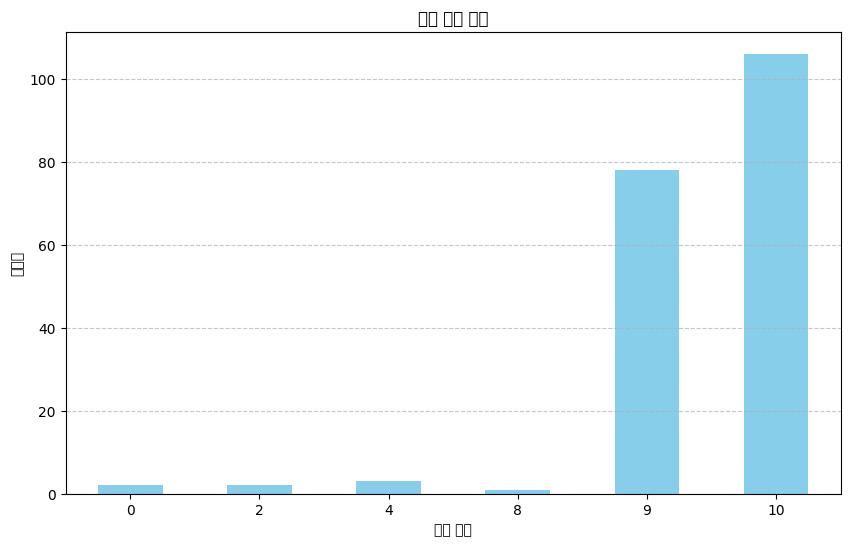

In [ ]:
import matplotlib.pyplot as plt
# 문장 개수별 빈도 계산
sentence_count_distribution = df['문장 개수'].value_counts().sort_index()

# 문장 개수 분포 시각화
plt.figure(figsize=(10, 6))
sentence_count_distribution.plot(kind='bar', color='skyblue')
plt.xlabel('문장 개수')
plt.ylabel('빈도수')
plt.title('문장 개수 분포')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 스킨/토너

### 링크 크롤링

In [ ]:
import re

# selenium driver 로드
driver = webdriver.Chrome(options=chrome_options)

# URL 구조
base_url = "https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010013&fltDispCatNo=&prdSort=01&pageIdx={}&rowsPerPage=48&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=0&aShowCnt=0&bShowCnt=0&cShowCnt=0&trackingCd=Cat100000100010013_Small&amplitudePageGubun=&t_page=&t_click=&midCategory=%EC%8A%A4%ED%82%A8%2F%ED%86%A0%EB%84%88&smallCategory=%EC%A0%84%EC%B2%B4&checkBrnds=&lastChkBrnd="

# 페이지 범위 설정
start_page = 1
end_page = 4

url_list = []

for page_num in range(start_page, end_page + 1):
    url = base_url.format(page_num)

    # 링크 전달
    driver.get(url)

    # CSS_SELECTOR를 활용해서 <a> 태그가 포함된 section들 찾기
    # data-index 속성이 있는 <li> 태그만 선택
    sections = driver.find_elements(By.CSS_SELECTOR, "li[data-index]")

    # 섹션 내에서 <a> 태그의 href 속성을 가져오기

    for section in sections:
        a_tags = section.find_elements(By.TAG_NAME, "a")
        for a in a_tags:
            href = a.get_attribute("href")
            if href and "javascript:;" not in href: # javascript:; 가 없을 경우만 href 속성 가져오기
                url_list.append(href)

#driver 종료
driver.quit()

len(url_list)

192

### 상품 정보와 리뷰 크롤링

In [ ]:
import re

def scrape_product_info_and_reviews(url):
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)  # URL 열기

    try:
        try:
          # 리뷰 버튼 클릭
          WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="reviewInfo"]/a'))).click()
        except:
          pass

        try:
          # 도움순 클릭
          WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="gdasSort"]/li[2]/a'))).click()
        except:
          pass

        try:
          # 체험단 클릭
          WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="searchType_3"]'))).click()
        except:
          pass

        # 브랜드 정보
        try:
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'p.prd_brand')))
            brand_name = element.text
        except:
            brand_name = "N/A"

        # 제품명
        try:
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'p.prd_name')))
            product_name = element.text
        except:
            product_name = "N/A"

        # 가격 정보
        try:
            # 원래 가격
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'span.price-1 strike')))
            original_price = int(element.text.replace(',', ''))
        except:
            original_price = None

        try:
            # 최종 가격
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'span.price-2 strong')))
            final_price = int(element.text.replace(',', ''))
        except:
            final_price = None

        # 리뷰 등급
        try:
            review_grade_element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'p#repReview b')))
            review_grade = float(review_grade_element.text.strip())
        except:
            review_grade = None

        # 리뷰 수
        try:
            review_numbers_element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'p#repReview em')))
            review_numbers_text = review_numbers_element.text.strip('()').replace(',', '')
            review_numbers = int(re.sub(r'\D', '', review_numbers_text))
        except:
            review_numbers = None

        # 피부타입, 피부고민, 자극도 항목별 퍼센트 크롤링

        try:
            # 피부타입
            percentages = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'dl.poll_type2.type3 ul.list li em.per')))
            dry = int(percentages[0].text.strip('%'))
            combination = int(percentages[1].text.strip('%'))
            oily = int(percentages[2].text.strip('%'))
        except:
            dry = combination = oily = None

        try:
            # 피부고민
            percentages = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'dl.poll_type2.type3 ul.list li em.per')))
            moisturizing = int(percentages[3].text.strip('%'))
            soothing = int(percentages[4].text.strip('%'))
            whitening = int(percentages[5].text.strip('%'))
        except:
            moisturizing = soothing = whitening = None

        try:
            # 자극도
            percentages = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'dl.poll_type2.type3 ul.list li em.per')))
            no_irritation = int(percentages[6].text.strip('%'))
            moderate_irritation = int(percentages[7].text.strip('%'))
            yes_irritation = int(percentages[8].text.strip('%'))
        except:
            no_irritation = moderate_irritation = yes_irritation = None

        # 리뷰 수집
        reviews = []
        try:
            review_list = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'ul.inner_list > li')))
            for review in review_list:
                review_text = review.find_element(By.CSS_SELECTOR, 'div.txt_inner').text
                # 줄바꿈과 이모티콘 제거
                review_text = review_text.replace('\n', ' ').replace('\r', ' ')
                review_text = re.sub(r'[^\w\s,.!?]', '', review_text)
                reviews.append(review_text.strip())
        except:
            reviews = []

    finally:
        driver.quit()  # 드라이버 닫기

    # 데이터를 딕셔너리로 저장
    data = {
        "브랜드": [brand_name],
        "제품명": [product_name],
        "원래 가격": [original_price],
        "최종 가격": [final_price],
        "리뷰 등급": [review_grade],
        "리뷰 수": [review_numbers],
        "건성에 좋아요": [dry],
        "복합성에 좋아요": [combination],
        "지성에 좋아요": [oily],
        "보습에 좋아요": [moisturizing],
        "진정에 좋아요": [soothing],
        "주름/미백에 좋아요": [whitening],
        "자극없이 순해요": [no_irritation],
        "보통이에요": [moderate_irritation],
        "자극이 느껴져요": [yes_irritation],
        "리뷰": [reviews]
    }

    # 데이터프레임으로 만들기
    df = pd.DataFrame(data)

    return df

In [ ]:
import pandas as pd
from tqdm import tqdm  # tqdm 라이브러리를 임포트합니다.

# 데이터프레임을 저장할 빈 리스트 초기화
result_product_list = []

# 각 URL에 대해 데이터 스크래핑 실행
for link in tqdm(url_list, desc="Scraping progress"):
    product_df = scrape_product_info_and_reviews(link)
    result_product_list.append(product_df)

# 모든 데이터프레임을 하나로 연결
result_product_df = pd.concat(result_product_list, ignore_index=True)

# 데이터프레임 저장
result_product_df.to_excel("olive_young_essence_serum_ampoule.xlsx",index=False)
# result_product_df.to_excel("이정우_올리브영_크롤링_스킨토너.xlsx", index=False)

Scraping progress: 100%|██████████| 192/192 [1:34:10<00:00, 29.43s/it]


In [ ]:
# 문장 개수를 세는 함수
def count_sentences(review_list):
    return len(review_list)

# '리뷰' 컬럼의 각 리스트에 대해 문장 개수를 계산
result_product_df['문장 개수'] = result_product_df['리뷰'].apply(count_sentences)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

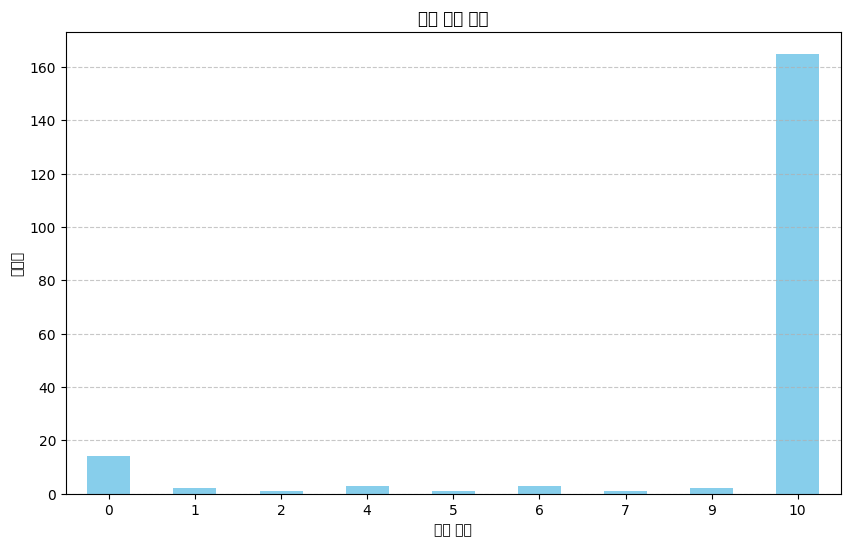

In [ ]:
import matplotlib.pyplot as plt
# 문장 개수별 빈도 계산
sentence_count_distribution = result_product_df['문장 개수'].value_counts().sort_index()

# 문장 개수 분포 시각화
plt.figure(figsize=(10, 6))
sentence_count_distribution.plot(kind='bar', color='skyblue')
plt.xlabel('문장 개수')
plt.ylabel('빈도수')
plt.title('문장 개수 분포')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 사용 방법

In [ ]:
# 엑셀 파일 4개 , df_products_embedded pickle파일 업로드 한 후
# 데이터 전처리 첫 셀만 실행 -> 추천시스템 부분 글로벌 변수 때문에
# 데이터 필터링,추천시스템 섹션 실행
# 이후 추천 시스템 실행 섹션 진행 하면서 추천 받아보기

# 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
import ast

# 데이터 불러오기
df_cream = pd.read_excel('olive_young_cream.xlsx')
df_essence_serum_ampoule = pd.read_excel('olive_young_essence_serum_ampoule.xlsx')
df_lotion = pd.read_excel('olive_young_lotion.xlsx')
df_skin_toner = pd.read_excel('olive_young_skin_toner.xlsx')

# 모든 제품이 들어있는 데이터 프레임 생성
df_products = pd.concat([df_cream, df_essence_serum_ampoule, df_lotion, df_skin_toner], ignore_index=True)
# 추천 시스템 부분 글로벌 변수때만 활용
df_product = pd.concat([df_cream, df_essence_serum_ampoule, df_lotion, df_skin_toner], ignore_index=True)

# 리뷰 등급을 제외한 모든 수치형 변수를 선택하고 float를 int로 변환
for column in df_products.columns:
    if df_products[column].dtype == 'float64' and column != '리뷰 등급':
        df_products[column] = df_products[column].astype('Int64')

# 리뷰 컬럼을 문자열에서 리스트로 변환
df_products['리뷰'] = df_products['리뷰'].apply(ast.literal_eval)

# 리뷰 길이가 8자 이하인 행을 삭제
df_products['리뷰 길이'] = df_products['리뷰'].apply(len)
df_products = df_products[df_products['리뷰 길이'] > 8]

# '리뷰 길이' 컬럼 삭제
df_products = df_products.drop(columns=['리뷰 길이'])

# '원래 가격'의 결측치를 '최종 가격'으로 대체
df_products['원래 가격'] = df_products['원래 가격'].fillna(df_products['최종 가격'])

In [ ]:
# 결측치 확인
null_rows = df_products[df_products['지성에 좋아요'].isnull()]
print(null_rows)

       브랜드                                          제품명  원래 가격  최종 가격  리뷰 등급  \
424    닥터지  닥터지 레드 블레미쉬 포 맨 올인원 톤 로션 50ml 기획(+젠틀폼 30ml)  32000  22400    4.6   
502   피지오겔         피지오겔 DMT 페이셜 로션 200ml 기획 (+50ml+GWP)  38000  38000    4.8   
617  바이오더마             [신규기획]바이오더마 센시비오 토너 250ml 1+1 기획  29000  24800    4.8   
720   메디큐브                         메디큐브 레드 토너 2.0 100ml  28000  22400    4.6   

     리뷰 수  건성에 좋아요  복합성에 좋아요  지성에 좋아요  보습에 좋아요  진정에 좋아요  주름/미백에 좋아요  자극없이 순해요  \
424    29     <NA>      <NA>     <NA>     <NA>     <NA>        <NA>      <NA>   
502  4849     <NA>      <NA>     <NA>     <NA>     <NA>        <NA>      <NA>   
617  3293     <NA>      <NA>     <NA>     <NA>     <NA>        <NA>      <NA>   
720    51     <NA>      <NA>     <NA>     <NA>     <NA>        <NA>      <NA>   

     보통이에요  자극이 느껴져요                                                 리뷰  
424   <NA>      <NA>  [여름에 선크림도 안바르는 남친을 위한 피부 소생 올인원으로 추천  여름에 선크림 ...  
502   <NA>      <NA>  [5세 딸 여아를 두고있는 엄마입니다. 피

In [ ]:
# 결측치가 있는 행 삭제
df_products = df_products.dropna(subset=['지성에 좋아요'])
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 675 entries, 0 to 767
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   브랜드         675 non-null    object 
 1   제품명         675 non-null    object 
 2   원래 가격       675 non-null    Int64  
 3   최종 가격       675 non-null    int64  
 4   리뷰 등급       675 non-null    float64
 5   리뷰 수        675 non-null    int64  
 6   건성에 좋아요     675 non-null    Int64  
 7   복합성에 좋아요    675 non-null    Int64  
 8   지성에 좋아요     675 non-null    Int64  
 9   보습에 좋아요     675 non-null    Int64  
 10  진정에 좋아요     675 non-null    Int64  
 11  주름/미백에 좋아요  675 non-null    Int64  
 12  자극없이 순해요    675 non-null    Int64  
 13  보통이에요       675 non-null    Int64  
 14  자극이 느껴져요    675 non-null    Int64  
 15  리뷰          675 non-null    object 
dtypes: Int64(10), float64(1), int64(2), object(3)
memory usage: 96.2+ KB


In [ ]:
# 할인율을 계산하여 새로운 컬럼 '할인율'에 추가
df_products['할인율'] = ((df_products['원래 가격'] - df_products['최종 가격']) / df_products['원래 가격']) * 100
df_products['할인율'] = df_products['할인율'].astype(int)
df_products.head()

<ipython-input-5-146de46d842d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['할인율'] = ((df_products['원래 가격'] - df_products['최종 가격']) / df_products['원래 가격']) * 100
<ipython-input-5-146de46d842d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['할인율'] = df_products['할인율'].astype(int)


,브랜드,제품명,원래 가격,최종 가격,리뷰 등급,리뷰 수,건성에 좋아요,복합성에 좋아요,지성에 좋아요,보습에 좋아요,진정에 좋아요,주름/미백에 좋아요,자극없이 순해요,보통이에요,자극이 느껴져요,리뷰,할인율
0,에스네이처,[8월올영픽/수분천재크림] 에스네이처 아쿠아 스쿠알란 수분크림 60ml 더블 기획 ...,43000,21300,4.8,24184,37,52,11,76,24,1,76,24,1,"[내돈내산 찐 한달후기 꾸준히 썼음 난 복합성에 티존유분, 속건조볼쪽 가끔 이마,...",50
1,토리든,[8월 올영픽/브랜든콜라보] 토리든 다이브인 수딩크림 더블 한정 기획 (100ml+...,42000,28600,4.8,13298,35,48,17,67,33,1,76,24,1,"[올리브영 혹은 토리든 측 답변 부탁 드립니다. 우선 저는 올리브영 골드 회원에, ...",31
2,메이크프렘,[베베더오리파우치 선착순증정] 메이크프렘 인테카 수딩크림 70ml 기획(+크림 31...,29000,19600,4.8,8330,26,58,17,32,68,1,82,18,1,"[인테카 수딩크림이라 촉촉한데 피부진정도 시켜줘서 좋아요, 환절기 피부에 좋대서 구...",32
3,에스트라,[NEW]에스트라 아토베리어365 크림 80ml,33000,29700,4.9,1918,56,41,4,81,19,1,82,18,1,[기존 버전만 열통 넘게 써온 입장에서 솔직한 리뷰 남깁니다! 제형차이 기존 ...,10
4,라로슈포제,라로슈포제 시카플라스트 밤 B5+ 100ml 기획 (+3ml 추가증정),39000,33350,4.8,16305,50,44,6,42,56,2,71,29,1,[ㅋㅋㅋ 제품은 좋은데 올리브영 진짜 장사 제대로 하시네요 앱데이? 뭐 행사로 쿠...,14


In [ ]:
# 구간 레이블 생성 함수
def create_labels(column_name):
    if column_name == '최종 가격':
        return ['매우 싸다', '싸다', '보통 가격', '비싸다', '매우 비싸다']
    elif column_name == '리뷰 수':
        return ['리뷰 매우 적음', '리뷰 적음', '리뷰 보통', '리뷰 많음', '리뷰 매우 많음']

# 각 컬럼을 5구간으로 나눠서 텍스트화 하는 함수
def categorize_column(column, column_name):
    labels = create_labels(column_name)
    try:
        categorized = pd.qcut(column, q=5, labels=labels)
    except ValueError:
        # 중복된 경계값이 제거되어 구간 수가 줄어든 경우
        unique_bins = pd.qcut(column, q=5, duplicates='drop').cat.categories.size
        categorized = pd.qcut(column, q=5, labels=labels[:unique_bins], duplicates='drop')
    return categorized.astype(str)  # Categorical을 문자열로 변환

# 각 컬럼을 5구간으로 나눠서 텍스트화
df_products['최종 가격'] = categorize_column(df_products['최종 가격'], '최종 가격')
df_products['리뷰 수'] = categorize_column(df_products['리뷰 수'], '리뷰 수')

<ipython-input-6-f2d8059dddc3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['최종 가격'] = categorize_column(df_products['최종 가격'], '최종 가격')
<ipython-input-6-f2d8059dddc3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['리뷰 수'] = categorize_column(df_products['리뷰 수'], '리뷰 수')


# 데이터 임베딩

In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

!pip install sentence_transformers

from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import re
import ast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 6.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# SentenceTransformer 모델 로드
model = SentenceTransformer('bespin-global/klue-sroberta-base-continue-learning-by-mnr')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# (필터링된) 데이터베이스와 sentence transformer 모델을 input으로 받아 제품명과 리뷰를 임베딩한 컬럼을 추가한 데이터베이스를 반환하는 함수
def add_embedding_columns(df, model):

  # 제품명 임베딩
  product_names = df['제품명'].astype(str).tolist()
  product_name_embeddings_dict = {}
  for product_name in tqdm(product_names, desc="Encoding product names"):
      product_name_embeddings_dict[product_name]= model.encode(product_name)

  # reviews_df에 임베딩 추가
  df['product_name_embedding'] = df['제품명'].map(product_name_embeddings_dict)

  # list 형식으로 변환
  df['product_name_embedding'] = df['product_name_embedding'].apply(lambda x: x.tolist())


  # 리뷰 내용 임베딩
  review_lists = df['리뷰']
  review_embeddings = []
  for review_list in tqdm(review_lists, desc="Encoding reviews"):
    review_embedding = []
    for review in review_list:
      review_embedding.append(model.encode(review))
    # 리스트 형식으로 변환
    review_embedding_list = [array.tolist() for array in review_embedding]
    review_embeddings.append(review_embedding_list)

  # reviews_df에 임베딩 추가
  df['review_content_embedding'] = review_embeddings

  # 가격 임베딩
  product_prices = df['최종 가격'].astype(str).tolist()
  product_price_embeddings_dict = {}
  for product_price in tqdm(product_prices, desc="Encoding price"):
      product_price_embeddings_dict[product_price]= model.encode(product_price)

  # reviews_df에 임베딩 추가
  df['product_price_embedding'] = df['최종 가격'].map(product_price_embeddings_dict)

  # list 형식으로 변환
  df['product_price_embedding'] = df['product_price_embedding'].apply(lambda x: x.tolist())

  # 리뷰 수 임베딩
  product_review_nums = df['리뷰 수'].astype(str).tolist()
  product_review_num_embeddings_dict = {}
  for product_review_num in tqdm(product_review_nums, desc="Encoding review numbers"):
      product_review_num_embeddings_dict[product_review_num]= model.encode(product_review_num)

  # reviews_df에 임베딩 추가
  df['product_review_num_embedding'] = df['리뷰 수'].map(product_review_num_embeddings_dict)

  # list 형식으로 변환
  df['product_review_num_embedding'] = df['product_review_num_embedding'].apply(lambda x: x.tolist())

  return df

# 데이터 필터링

In [ ]:
# 이모티콘 설정
HEADER = '🌟 '
PROMPT = '🔹 '
SUCCESS = '✔️ '
ERROR = '❌ '

def filter_products(df):
    # 피부타입 선택. 유효한 값을 입력할 때까지 숫자 입력을 받음.
    skin_type_options = {
        1: '건성',
        2: '복합성',
        3: '지성',
        4: '기타',
        5: '모른다'
    }
    print(f"{HEADER}피부타입을 선택해주세요:")
    for num, option in skin_type_options.items():
        print(f"{num}: {option}")

    while True:
        try:
            skin_type_choice_num = int(input(f"{PROMPT}입력 (숫자): "))
            if skin_type_choice_num in skin_type_options:
                skin_type_choice = skin_type_options[skin_type_choice_num]
                print(f"{SUCCESS}선택한 피부타입: {skin_type_choice}\n")
                break
            else:
                print(f"{ERROR}잘못된 입력입니다. 1에서 5 사이의 숫자를 선택해주세요.\n")
        except ValueError:
            print(f"{ERROR}잘못된 입력입니다. 숫자를 입력해주세요.\n")

    # 피부고민 선택. 유효한 값을 입력할 때까지 숫자 입력을 받음.
    skin_concern_options = {
        1: '보습',
        2: '진정',
        3: '주름/미백',
        4: '기타',
        5: '모른다'
    }
    print(f"{HEADER}피부고민을 선택해주세요:")
    for num, option in skin_concern_options.items():
        print(f"{num}: {option}")

    while True:
        try:
            skin_concern_choice_num = int(input(f"{PROMPT}입력 (숫자): "))
            if skin_concern_choice_num in skin_concern_options:
                skin_concern_choice = skin_concern_options[skin_concern_choice_num]
                print(f"{SUCCESS}선택한 피부고민: {skin_concern_choice}\n")
                break
            else:
                print(f"{ERROR}잘못된 입력입니다. 1에서 5 사이의 숫자를 선택해주세요.\n")
        except ValueError:
            print(f"{ERROR}잘못된 입력입니다. 숫자를 입력해주세요.\n")

    # 자극도 선택. 유효한 값을 입력할 때까지 숫자 입력을 받음.
    irritation_options = {
        1: '매우 예민한 편',
        2: '보통 예민함',
        3: '예민하지 않음',
        4: '기타',
        5: '모른다'
    }
    print(f"{HEADER}피부 예민도를 선택해주세요:")
    for num, option in irritation_options.items():
        print(f"{num}: {option}")

    while True:
        try:
            irritation_choice_num = int(input(f"{PROMPT}입력 (숫자): "))
            if irritation_choice_num in irritation_options:
                irritation_choice = irritation_options[irritation_choice_num]
                print(f"{SUCCESS}선택한 피부 예민도: {irritation_choice}\n")
                break
            else:
                print(f"{ERROR}잘못된 입력입니다. 1에서 5 사이의 숫자를 선택해주세요.\n")
        except ValueError:
            print(f"{ERROR}잘못된 입력입니다. 숫자를 입력해주세요.\n")

    # 피부 타입 필터링
    if skin_type_choice in ['건성', '복합성', '지성']:
        column_name_skin_type = f'{skin_type_choice}에 좋아요'
        threshold_skin_type = df[column_name_skin_type].quantile(0.5)
        filtered_df = df[df[column_name_skin_type] >= threshold_skin_type]
    else:
        filtered_df = df

    # 피부 고민 필터링
    if skin_concern_choice in ['보습', '진정', '주름/미백']:
        column_name_skin_concern = f'{skin_concern_choice}에 좋아요'
        threshold_skin_concern = filtered_df[column_name_skin_concern].quantile(0.5)
        filtered_df = filtered_df[filtered_df[column_name_skin_concern] >= threshold_skin_concern]

    # 자극도 필터링
    if irritation_choice in ['매우 예민한 편', '보통 예민함', '예민하지 않음']:
        if irritation_choice == '매우 예민한 편':
            threshold_irritation = filtered_df['자극없이 순해요'].quantile(0.5)
            filtered_df = filtered_df[filtered_df['자극없이 순해요'] >= threshold_irritation]
        elif irritation_choice == '보통 예민함':
            threshold_irritation = filtered_df['보통이에요'].quantile(0.5)
            filtered_df = filtered_df[filtered_df['보통이에요'] >= threshold_irritation]

    return filtered_df

# 추천 시스템

In [ ]:
# 유사도 계산 함수
def calculate_cosine_similarity(query_embedding, embeddings):
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    return similarities

# 가중 평균 계산 함수
def weighted_average(similarities):
    weights = [2**i for i in range(len(similarities) - 1, -1, -1)]
    weighted_sum = sum(sim * weight for sim, weight in zip(similarities, weights))
    total_weight = sum(weights)
    return weighted_sum / total_weight

# 정규화 함수 (0점에서 100점까지)
def normalize(column):
    min_value = column.min()
    max_value = column.max()
    normalized_column = 100 * (column - min_value) / (max_value - min_value)
    return normalized_column

# (필터링, 임베딩된) 데이터베이스를 input으로 받아 유사도를 계산해서 제품 하나를 추천해주는 함수
def recommendation(df):
    while True:
        query = input(f"{HEADER}추천받고 싶은 제품에 대해 자유롭게 작성해주세요.\n예) 갑자기 여드름 났을 때 진정시키기 좋은 크림\n입력: ")
        query_embedding = model.encode(query)

        # 제품명과 유사도 계산 칼럼 추가 (0점 ~ 100점)
        product_name_embeddings = np.array(df['product_name_embedding'].tolist())
        df['cosine_similarity_product_name'] = normalize(calculate_cosine_similarity(query_embedding, product_name_embeddings))

        # 리뷰와 유사도 계산 칼럼 추가 (0점 ~ 100점)
        df['cosine_similarity_reviews'] = np.nan

        for idx, product in df['review_content_embedding'].items():
            review_cosine_similarities = []
            for review in product:
                review_cosine_similarity = calculate_cosine_similarity(query_embedding, [review])
                review_cosine_similarities.append(review_cosine_similarity)

            # 유사도를 내림차순으로 정렬 후 가중 평균 계산
            review_cosine_similarities.sort(reverse=True)
            weighted_avg_cosine_similarity = weighted_average(review_cosine_similarities)
            df.at[idx, 'cosine_similarity_reviews'] = weighted_avg_cosine_similarity

        df['cosine_similarity_reviews'] = normalize(df['cosine_similarity_reviews'])

        # 가격과 유사도 계산 칼럼 추가 (0점 ~ 100점)
        product_price_embeddings = np.array(df['product_price_embedding'].tolist())
        df['cosine_similarity_product_price'] = normalize(calculate_cosine_similarity(query_embedding, product_price_embeddings))

        # 리뷰 수와 유사도 계산 칼럼 추가 (0점 ~ 100점)
        product_review_num_embeddings = np.array(df['product_review_num_embedding'].tolist())
        df['cosine_similarity_product_review_num'] = normalize(calculate_cosine_similarity(query_embedding, product_review_num_embeddings))

        # 할인율 반영 여부 결정
        while True:
            want_discount = input(f"{HEADER}할인율 높은 제품을 추천해드릴까요? [Y/N]로 대답해주세요.\n입력: ")
            if want_discount in ['Y', 'N']:
                print(f"{SUCCESS}할인율이 {'높은' if want_discount == 'Y' else '상관없는'} 제품을 추천해드리겠습니다.\n")
                break
            else:
                print(f"{ERROR}잘못된 입력 값입니다. Y 또는 N을 입력해주세요.\n")

        # 할인율 점수 계산 칼럼 추가 (0점 ~ 100점)
        if want_discount == 'Y':
            df['discount_score'] = normalize(df['할인율'])
        else:
            df['discount_score'] = 0

        # 점수가 가장 높은 최종 추천 제품 찾기
        df['final_score'] = (
            df['cosine_similarity_product_name'] * 3.5 +
            df['cosine_similarity_reviews'] * 3.5 +
            df['cosine_similarity_product_price'] +
            df['cosine_similarity_product_review_num'] +
            df['discount_score']
        )

        best_product_idx = df['final_score'].idxmax()
        best_product = df.loc[best_product_idx, [
            '제품명', '브랜드', '원래 가격', '최종 가격', '리뷰 등급', '리뷰 수',
            '건성에 좋아요', '복합성에 좋아요', '지성에 좋아요', '보습에 좋아요',
            '진정에 좋아요', '주름/미백에 좋아요', '자극없이 순해요', '보통이에요',
            '자극이 느껴져요', '리뷰', '할인율'
        ]]

        # 가격과 리뷰 등급을 원하는 형식으로 변환
        global df_product
        best_product['원래 가격'] = f"{best_product['원래 가격']}원"
        best_product['최종 가격'] = f"{df_product.loc[best_product_idx, '최종 가격']}원"
        best_product['리뷰 등급'] = f"{best_product['리뷰 등급']}점"
        best_product['리뷰 수'] = f"{df_product.loc[best_product_idx, '리뷰 수']}개"
        best_product['건성에 좋아요'] = f"{best_product['건성에 좋아요']}점"
        best_product['복합성에 좋아요'] = f"{best_product['복합성에 좋아요']}점"
        best_product['지성에 좋아요'] = f"{best_product['지성에 좋아요']}점"
        best_product['보습에 좋아요'] = f"{best_product['보습에 좋아요']}점"
        best_product['진정에 좋아요'] = f"{best_product['진정에 좋아요']}점"
        best_product['주름/미백에 좋아요'] = f"{best_product['주름/미백에 좋아요']}점"
        best_product['자극없이 순해요'] = f"{best_product['자극없이 순해요']}점"
        best_product['보통이에요'] = f"{best_product['보통이에요']}점"
        best_product['자극이 느껴져요'] = f"{best_product['자극이 느껴져요']}점"
        best_product['할인율'] = f"{best_product['할인율']}%"

        print(f"\n{SUCCESS}추천 제품은 '{best_product['제품명']}'입니다. 이 제품은 '{best_product['브랜드']}' 브랜드의 제품이며, 현재 {best_product['할인율']} 할인 행사로 {best_product['최종 가격']}에 판매하고 있습니다.")
        print("\n제품의 상세 정보는 다음과 같습니다:")

        best_product_dict = best_product.to_dict()
        for key, value in best_product_dict.items():
            print(f"{PROMPT}{key}: {value}")

        while True:
            satisfied = input(f"{HEADER}추천 결과에 만족하시나요? [Y/N]로 대답해주세요.\n입력: ")
            if satisfied == 'Y':
                print(f"{SUCCESS}올리브영 추천 시스템을 이용해주셔서 감사합니다.\n")
                break
            elif satisfied == 'N':
                print(f"{ERROR}죄송합니다. 다시 한번 제품을 추천드리도록 하겠습니다.\n")
                break
            else:
                print(f"{ERROR}잘못된 입력 값입니다. Y 또는 N을 입력해주세요.\n")

        if satisfied == 'Y':
            break

# 추천 시스템 실행

In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

!pip install sentence_transformers

from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import re
import ast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 8.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# SentenceTransformer 모델 로드
model = SentenceTransformer('bespin-global/klue-sroberta-base-continue-learning-by-mnr')

# 임베딩 함수 실행
# df_products_embedded = add_embedding_columns(df_products, model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# import pickle

# # 데이터프레임을 Pickle 파일로 저장
# with open('df_products_embedded.pkl', 'wb') as file:
#     pickle.dump(df_products_embedded, file)

In [ ]:
import pickle

# Pickle 파일에서 데이터프레임 불러오기
with open('df_products_embedded.pkl', 'rb') as file:
    df_products_embedded = pickle.load(file)

In [ ]:
# 필터링 함수 실행
df_products_embedded_filtered = filter_products(df_products_embedded)

# 추천시스템 실행
recommendation(df_products_embedded_filtered)

🌟 피부타입을 선택해주세요:
1: 건성
2: 복합성
3: 지성
4: 기타
5: 모른다
🔹 입력 (숫자): 1
✔️ 선택한 피부타입: 건성

🌟 피부고민을 선택해주세요:
1: 보습
2: 진정
3: 주름/미백
4: 기타
5: 모른다
🔹 입력 (숫자): 3
✔️ 선택한 피부고민: 주름/미백

🌟 피부 예민도를 선택해주세요:
1: 매우 예민한 편
2: 보통 예민함
3: 예민하지 않음
4: 기타
5: 모른다
🔹 입력 (숫자): 1
✔️ 선택한 피부 예민도: 매우 예민한 편

🌟 추천받고 싶은 제품에 대해 자유롭게 작성해주세요.
예) 갑자기 여드름 났을 때 진정시키기 좋은 크림
입력: 미스트 
🌟 할인율 높은 제품을 추천해드릴까요? [Y/N]로 대답해주세요.
입력: Y
✔️ 할인율이 높은 제품을 추천해드리겠습니다.


✔️ 추천 제품은 '[김지영 PICK][1등주름앰플] 메디톡스 뉴라덤 코어타임 앰플 15ml'입니다. 이 제품은 '뉴라덤' 브랜드의 제품이며, 현재 6% 할인 행사로 29800원에 판매하고 있습니다.

제품의 상세 정보는 다음과 같습니다:
🔹 제품명: [김지영 PICK][1등주름앰플] 메디톡스 뉴라덤 코어타임 앰플 15ml
🔹 브랜드: 뉴라덤
🔹 원래 가격: 32000원
🔹 최종 가격: 29800원
🔹 리뷰 등급: 5.0점
🔹 리뷰 수: 871개
🔹 건성에 좋아요: 42점
🔹 복합성에 좋아요: 54점
🔹 지성에 좋아요: 4점
🔹 보습에 좋아요: 36점
🔹 진정에 좋아요: 9점
🔹 주름/미백에 좋아요: 55점
🔹 자극없이 순해요: 89점
🔹 보통이에요: 11점
🔹 자극이 느껴져요: 1점
🔹 리뷰: ['피부가 예민하고 피부염이 있는 사람에게 좋은 제품의 기준은 염증피부에 자극 유무 여부와 제품의 효과가 있냐인데요. 적어도 저의 경우에는 그래요. 아무리 좋다고해도 염증 부분이 아프고 자극이 되면 말짱 도루묵이거든요. 이번에도 조마조마한 마음으로 사용해 봤어요. 얼굴에 올렸을 때 제형이 젤에 가까워 발림성이 참 좋았어요. 그리고 염증 부분에 전혀 자극이 없어서 기

## 테스트1

In [ ]:
# 필터링 함수 실행
df_products_embedded_filtered = filter_products(df_products_embedded)

# 추천시스템 실행
recommendation(df_products_embedded_filtered)

🌟 피부타입을 선택해주세요:
1: 건성
2: 복합성
3: 지성
4: 기타
5: 모른다
🔹 입력 (숫자): 1
✔️ 선택한 피부타입: 건성

🌟 피부고민을 선택해주세요:
1: 보습
2: 진정
3: 주름/미백
4: 기타
5: 모른다
🔹 입력 (숫자): 보습
❌ 잘못된 입력입니다. 숫자를 입력해주세요.

🔹 입력 (숫자): 1
✔️ 선택한 피부고민: 보습

🌟 피부 예민도를 선택해주세요:
1: 매우 예민한 편
2: 보통 예민함
3: 예민하지 않음
4: 기타
5: 모른다
🔹 입력 (숫자): 1
✔️ 선택한 피부 예민도: 매우 예민한 편

🌟 추천받고 싶은 제품에 대해 자유롭게 작성해주세요.
예) 갑자기 여드름 났을 때 진정시키기 좋은 크림
입력: 극건성에 좋은 꾸덕한 크림
🌟 할인율 높은 제품을 추천해드릴까요? [Y/N]로 대답해주세요.
입력: Y
✔️ 할인율이 높은 제품을 추천해드리겠습니다.


✔️ 추천 제품은 '한율 빨간쌀 보습탄력 크림 55ml'입니다. 이 제품은 '한율' 브랜드의 제품이며, 현재 15% 할인 행사로 41600원에 판매하고 있습니다.

제품의 상세 정보는 다음과 같습니다:
🔹 제품명: 한율 빨간쌀 보습탄력 크림 55ml
🔹 브랜드: 한율
🔹 원래 가격: 49000원
🔹 최종 가격: 41600원
🔹 리뷰 등급: 4.8점
🔹 리뷰 수: 196개
🔹 건성에 좋아요: 63점
🔹 복합성에 좋아요: 34점
🔹 지성에 좋아요: 3점
🔹 보습에 좋아요: 80점
🔹 진정에 좋아요: 14점
🔹 주름/미백에 좋아요: 6점
🔹 자극없이 순해요: 82점
🔹 보통이에요: 18점
🔹 자극이 느껴져요: 0점
🔹 리뷰: ['70대의 고모에게 선물해드린 크림이에요. 이것만 쓰신다고 해요. 저도 샘플 써봤을 때 좀 리치하게 느껴졌는데요. 최근 건성화가 진행 중이라서 저도 얇게 써볼까 생각하고 있어요. 향이 조금 진하게 느껴져서 향은 호불호가 있을 거 같네요', '피부가 건조하고 푸석해져서 기초라인 한율 빨간쌀 전부 바꿔봤습니다. 건조함 많이 개선되었어요.', '피부가 너무 건조

##테스트2

In [ ]:
# 필터링 함수 실행
df_products_embedded_filtered = filter_products(df_products_embedded)

# 추천시스템 실행
recommendation(df_products_embedded_filtered)

🌟 피부타입을 선택해주세요:
1: 건성
2: 복합성
3: 지성
4: 기타
5: 모른다
🔹 입력 (숫자): 2
✔️ 선택한 피부타입: 복합성

🌟 피부고민을 선택해주세요:
1: 보습
2: 진정
3: 주름/미백
4: 기타
5: 모른다
🔹 입력 (숫자): 2
✔️ 선택한 피부고민: 진정

🌟 피부 예민도를 선택해주세요:
1: 매우 예민한 편
2: 보통 예민함
3: 예민하지 않음
4: 기타
5: 모른다
🔹 입력 (숫자): 2
✔️ 선택한 피부 예민도: 보통 예민함

🌟 추천받고 싶은 제품에 대해 자유롭게 작성해주세요.
예) 갑자기 여드름 났을 때 진정시키기 좋은 크림
입력: 가격이 싸고 여름에 쓰기 좋은 토너
🌟 할인율 높은 제품을 추천해드릴까요? [Y/N]로 대답해주세요.
입력: Y
✔️ 할인율이 높은 제품을 추천해드리겠습니다.


✔️ 추천 제품은 '[이동욱PICK] 더마펌 수딩 리페어 토너 R4 200ml+200ml 기획'입니다. 이 제품은 '더마펌' 브랜드의 제품이며, 현재 30% 할인 행사로 24500원에 판매하고 있습니다.

제품의 상세 정보는 다음과 같습니다:
🔹 제품명: [이동욱PICK] 더마펌 수딩 리페어 토너 R4 200ml+200ml 기획
🔹 브랜드: 더마펌
🔹 원래 가격: 35000원
🔹 최종 가격: 24500원
🔹 리뷰 등급: 4.7점
🔹 리뷰 수: 103개
🔹 건성에 좋아요: 26점
🔹 복합성에 좋아요: 67점
🔹 지성에 좋아요: 7점
🔹 보습에 좋아요: 43점
🔹 진정에 좋아요: 53점
🔹 주름/미백에 좋아요: 4점
🔹 자극없이 순해요: 60점
🔹 보통이에요: 40점
🔹 자극이 느껴져요: 0점
🔹 리뷰: ['피부타입 저는 복합성 피부타입인데, 지복합, 건성 할 거 없이 다 너무 잘 맞을 것같은 토너로 챱토가 잘 어울리는 앰플같은 물토너입니다!  사용하기 좋은 계절 여름이라고 생각합니다, 여름에는 아무래도 피부타입이 외부 온도 및 자극에 의해서 변화하시는 분들이 있다고생각해요! 그래서 이 토너처럼 모공, 진정, 수분에 좋은 토너를 사용하시는 

##테스트3

In [ ]:
# 필터링 함수 실행
df_products_embedded_filtered = filter_products(df_products_embedded)

# 추천시스템 실행
recommendation(df_products_embedded_filtered)

🌟 피부타입을 선택해주세요:
1: 건성
2: 복합성
3: 지성
4: 기타
5: 모른다
🔹 입력 (숫자): 2
✔️ 선택한 피부타입: 복합성

🌟 피부고민을 선택해주세요:
1: 보습
2: 진정
3: 주름/미백
4: 기타
5: 모른다
🔹 입력 (숫자): 1
✔️ 선택한 피부고민: 보습

🌟 피부 예민도를 선택해주세요:
1: 매우 예민한 편
2: 보통 예민함
3: 예민하지 않음
4: 기타
5: 모른다
🔹 입력 (숫자): 3
✔️ 선택한 피부 예민도: 예민하지 않음

🌟 추천받고 싶은 제품에 대해 자유롭게 작성해주세요.
예) 갑자기 여드름 났을 때 진정시키기 좋은 크림
입력: 사계절 공용으로 쓸 수 있는 수분크림 추천!!
🌟 할인율 높은 제품을 추천해드릴까요? [Y/N]로 대답해주세요.
입력: Y
✔️ 할인율이 높은 제품을 추천해드리겠습니다.


✔️ 추천 제품은 '비욘드 엔젤아쿠아 보습 장벽 로션 200ml'입니다. 이 제품은 '비욘드' 브랜드의 제품이며, 현재 26% 할인 행사로 16900원에 판매하고 있습니다.

제품의 상세 정보는 다음과 같습니다:
🔹 제품명: 비욘드 엔젤아쿠아 보습 장벽 로션 200ml
🔹 브랜드: 비욘드
🔹 원래 가격: 23000원
🔹 최종 가격: 16900원
🔹 리뷰 등급: 4.9점
🔹 리뷰 수: 122개
🔹 건성에 좋아요: 31점
🔹 복합성에 좋아요: 66점
🔹 지성에 좋아요: 3점
🔹 보습에 좋아요: 77점
🔹 진정에 좋아요: 23점
🔹 주름/미백에 좋아요: 0점
🔹 자극없이 순해요: 76점
🔹 보통이에요: 24점
🔹 자극이 느껴져요: 1점
🔹 리뷰: ['토너랑 같이 구매했어요. 가성비 좋고 촉촉하게 발려요. 무난하게 사용할 수 있어요', '약간 레몬향이 나는거 같은 로션인데 몸에 발라주고 말리면 끈적임도 덜하고 전 너무 잘쓰고 있어요!!', '비욘드 아쿠아 크림을 사용했을 때 순하고 피부에도 잘 맞았던 기억이 있습니다. 기초 제품도 잘 맞았으면 좋겠네요', '세일해서 사긴 했는데 제품 리뷰란이 죄다 제품 제공 광고로 덮여있는 거 미리